## Data analysis code for gain=1000 and gain=5000 data taken on 02/25/2025 and 02/27/2025. Plots histogram and fits with a Gaussian.

In [8]:
import numpy as np  
import matplotlib.pyplot as plt
import re
import os
from scipy import optimize
from scipy.ndimage import gaussian_filter
import h5py

## Define functions for Gaussian fitting

In [9]:
def gaussian(p, x):
    return p[0]/(p[1]*(2*np.pi)**.5)*np.exp(-.5*(x-p[2])**2/(p[1]**2))
def exp(p, x):
    return p[0]*p[1]*np.exp(-p[1]*(x-p[2]))

In [10]:
def gaussian_fit(counts,probability,probability_uncertainty,p0,show_details):
    def residual(p, x, y,dy):
        return (gaussian(p, x)-y)/dy
    pf, cov, info, mesg, success = optimize.leastsq(residual, p0, args = (counts, probability, probability_uncertainty), full_output=1, maxfev=5000)
    print('AAA')
    print(pf)
    print(cov)
    print(info)
    print(mesg)
    print(success)
    if cov is None:
        print('Fit did not converge')
        print('Success code:', success)
        print(mesg)
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(111)
        ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data')
        x = np.linspace(min(counts),max(counts),1000)
        ax.plot(x, readout_noise_and_CIC(p0, x), 'b-', label = 'Guess')
        ax.legend()
        ax.set_title('CIC measurement')
        ax.set_xlabel('AD count')
        ax.set_ylabel('Probability')
        ax.set_yscale('log')
        ax.grid()
        plt.show()
    else:
        pferr = [np.sqrt(cov[i,i]) for i in range(len(pf))]
        if show_details:
            print('Fit Converged')
            chisq = sum(info['fvec']*info['fvec'])
            dof = abs(len(counts)-len(pf))
            print('Converged with chi-squared', chisq)
            print('Number of degrees of freedom, dof =',dof)
            print('Reduced chi-squared', chisq/dof)
            print('Inital guess values:')
            print('  p0 =', p0)
            print('Best fit values:')
            print('  pf =', list(pf))
            print('Uncertainties in the best fit values:')
            print('  pferr =', pferr)
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=.5)
            x = np.linspace(min(counts),max(counts),1000)
            ax.set_yscale('log')
            ax.plot(x, readout_noise_and_CIC(pf, x), 'r-', label = 'Fit')
            # ax.plot(x, readout_noise_and_CIC(p0, x), 'b-', label = 'Guess')
            ax.set_title('CIC measurement')
            ax.set_xlabel('AD count')
            ax.set_ylabel('Probability')
            ax.grid()
            ax.legend(loc=3)
            plt.tight_layout()
            plt.show()
            print("serial CIC: {}%".format(round(float(pf[2])*100,2)))
            print("parallel CIC: {}%".format(round(float(pf[0])*100,2)))
            print("gain: {}".format(round(4.31/pf[1])))
            print("readout noise: {} electrons".format(round(pf[4]*pf[1],4)))
    return pf

# Plot gain=1000 data
Note: Only binning=1x1 data were taken for gain=1000.

In [78]:
folder_paths = [r'C:\Users\PolyEDM\labscript-suite\userlib\analysislib\lyman29\gain1000\100mw', 
                r'C:\Users\PolyEDM\labscript-suite\userlib\analysislib\lyman29\gain1000\10mw', 
                r'C:\Users\PolyEDM\labscript-suite\userlib\analysislib\lyman29\gain1000\1mw',
                r'C:\Users\PolyEDM\labscript-suite\userlib\analysislib\lyman29\gain1000\100uw',
                r'C:\Users\PolyEDM\labscript-suite\userlib\analysislib\lyman29\gain1000\0W']

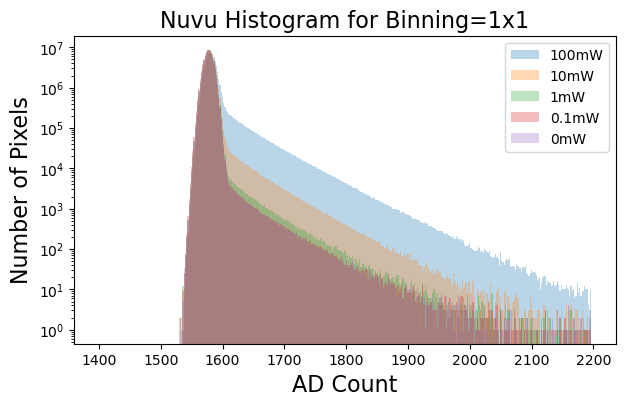

In [85]:
# For binning=1x1
all_images_binning = np.full((5, 300, 512, 512), np.NaN)
count_a = 0
for folder_path in folder_paths:
    count_b = 0
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            all_images_binning[count_a, count_b, :, :] = image_data
        count_b += 1
        if count_b==299:
            break
    count_a += 1

plt.figure(figsize=(7, 4), num = 'histograms')

#get histogram for total data
bins = np.arange(1400, 2200, 2)
# bins = np.arange(14400, 3000, 10)
for i, images in enumerate(all_images_binning):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), alpha = 0.3) #label='seq %.4i'%(seqs[i]))

# #get histogram for spatially averaged data (is this even useful? It's not just dividing each bin by 300..)
# bins = np.arange(1500, 1700, 2)
# for i, images in enumerate(all_images_binning1):
#     averaged_image = np.nanmean(images, axis=0)
#     hist, bin_edges = np.histogram(averaged_image, bins=bins)  # Adjust the number of bins as needed
#     plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), alpha = 0.3) #label='seq %.4i'%(seqs[i]))
    
plt.title('Nuvu Histogram for Binning=1x1', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend(['100mW', '10mW', '1mW', '0.1mW', '0mW'])
plt.show()

# Plot gain=5000 data

In [3]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\02\27'
seq_binning1 = [24, 23, 18, 17, 12] #order = [100mW, 10mW, 1mW, 0.1mW, 0mW]
seq_binning2 = [25, 22, 19, 16, 13]
seq_binning4 = [26, 21, 20, 15, 14]

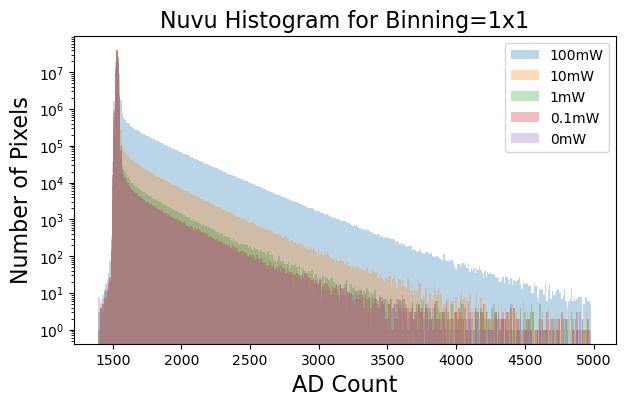

In [4]:
# For binning=1x1
all_images_binning1 = np.full((5, 300, 512, 512), np.NaN)
count_a = 0
for seq in seq_binning1:
    folder_path = folder_path_day + '\\%.4i'%seq
    count_b = 0
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            all_images_binning1[count_a, count_b, :, :] = image_data
        count_b += 1
    count_a += 1

plt.figure(figsize=(7, 4), num = 'histograms')

#get histogram for total data
# bins = np.arange(1400, 2500, 2)
bins = np.arange(1400, 5000, 10)
for i, images in enumerate(all_images_binning1):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), alpha = 0.3) #label='seq %.4i'%(seqs[i]))

# #get histogram for spatially averaged data (is this even useful? It's not just dividing each bin by 300..)
# bins = np.arange(1500, 1700, 2)
# for i, images in enumerate(all_images_binning1):
#     averaged_image = np.nanmean(images, axis=0)
#     hist, bin_edges = np.histogram(averaged_image, bins=bins)  # Adjust the number of bins as needed
#     plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), alpha = 0.3) #label='seq %.4i'%(seqs[i]))
    
plt.title('Nuvu Histogram for Binning=1x1', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend(['100mW', '10mW', '1mW', '0.1mW', '0mW'])
plt.show()

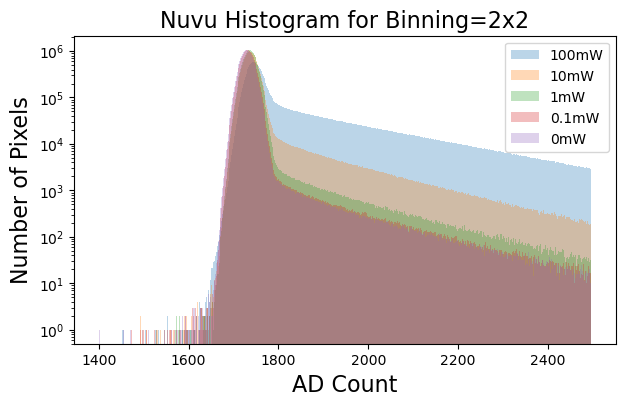

In [5]:
# For binning=2x2
all_images_binning2 = np.full((5, 300, 256, 256), np.nan)
count_a = 0
for seq in seq_binning2:
    folder_path = folder_path_day + '\\%.4i'%seq
    count_b = 0
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            all_images_binning2[count_a, count_b, :, :] = image_data
        count_b += 1
    count_a += 1

plt.figure(figsize=(7, 4), num = 'histograms')
bins = np.arange(1400, 2500, 2)
# bins = np.arange(1400, 5000, 10)
for i, images in enumerate(all_images_binning2):
    hist, bin_edges = np.histogram(images, bins=bins)  
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), alpha = 0.3) #label='seq %.4i'%(seqs[i]))
    
plt.title('Nuvu Histogram for Binning=2x2', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend(['100mW', '10mW', '1mW', '0.1mW', '0mW'])
plt.show()

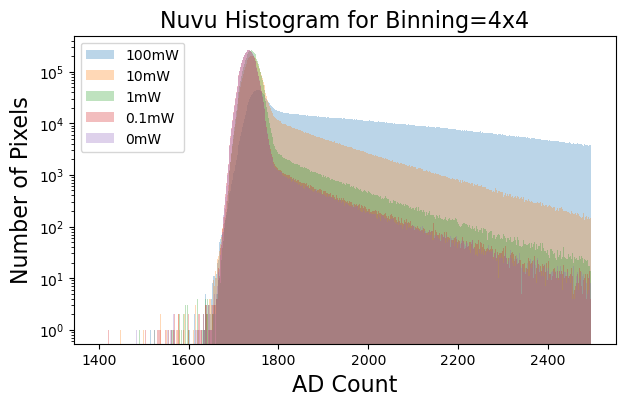

In [77]:
# For binning=4x4
all_images_binning4 = np.full((5, 300, 128, 128), np.nan)
count_a = 0
for seq in seq_binning4:
    folder_path = folder_path_day + '\\%.4i'%seq
    count_b = 0
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            all_images_binning4[count_a, count_b, :, :] = image_data
        count_b += 1
    count_a += 1

plt.figure(figsize=(7, 4), num = 'histograms')
bins = np.arange(1400, 2500, 2)
# bins = np.arange(1400, 5000, 10)
for i, images in enumerate(all_images_binning4):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), alpha = 0.3) #label='seq %.4i'%(seqs[i]))


    
    
plt.title('Nuvu Histogram for Binning=4x4', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)
# plt.xlim([1500,2500])
plt.yscale('log', base=10)
plt.legend(['100mW', '10mW', '1mW', '0.1mW', '0mW'])
plt.show()

In [107]:
%matplotlib qt

In [112]:
labels = ['100mW', '10mW', '1mW', '0.1mW', '0mW']

plt.figure(figsize = (10,10), num = 'spatial average')
plt.subplot(1,5,1)

for i, images in enumerate(all_images_binning1):
    plt.subplot(1,5, i+1)
    plt.imshow(np.log(np.nanmean(images, axis = 0) -1500))
    plt.title(labels[i])
    plt.colorbar()


In [12]:
%matplotlib qt

In [39]:
# For binning=1x1
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\02\27'
seq_binning1 = [23,27]
labels = ['Without Acktar', 'With Acktar']

all_images_binning1 = np.full((2, 300, 512, 512), np.NaN)
count_a = 0
for seq in seq_binning1:
    folder_path = folder_path_day + '\\%.4i'%seq
    count_b = 0
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            all_images_binning1[count_a, count_b, :, :] = image_data
        count_b += 1
    count_a += 1

plt.figure(figsize=(7, 4), num = 'histograms')

#get histogram for total data
# bins = np.arange(1400, 2500, 2)
bins = np.arange(1400, 5000, 10)
for i, images in enumerate(all_images_binning1):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), alpha = 0.3, label = labels[i]) #label='seq %.4i'%(seqs[i]))


# #get histogram for spatially averaged data (is this even useful? It's not just dividing each bin by 300..)
# bins = np.arange(1500, 1700, 2)
# for i, images in enumerate(all_images_binning1):
#     averaged_image = np.nanmean(images, axis=0)
#     hist, bin_edges = np.histogram(averaged_image, bins=bins)  # Adjust the number of bins as needed
#     plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), alpha = 0.3) #label='seq %.4i'%(seqs[i]))
counting_threshold = 1567
counts = np.array([np.mean(all_images_binning1[0,:,:,:]>counting_threshold), np.mean(all_images_binning1[1,:,:,:]>counting_threshold)])
plt.axvline(x = counting_threshold, label = 'threshold', c = 'k')

plt.title('Nuvu Histogram for Binning=1x1 \n without_acktar = %.4f  \n with_acktar = %.4f'%(counts[0],counts[1]),
          fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend()
plt.show()

In [80]:
# For binning=1x1
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\02\27'
seq_binning1 = [23,27,28]
labels = ['10mW light, no acktar', '10mW light, with acktar','No light']

all_images_binning1 = np.full((len(seq_binning1), 300, 512, 512), np.NaN)
count_a = 0
for seq in seq_binning1:
    folder_path = folder_path_day + '\\%.4i'%seq
    count_b = 0
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            all_images_binning1[count_a, count_b, :, :] = image_data
        count_b += 1
    count_a += 1


counting_threshold = 1567
counts = np.mean(all_images_binning1>counting_threshold, axis = (1,2,3))


plt.figure(figsize=(7, 4), num = 'histograms')

bins = np.arange(1400, 5000, 10)
for i, images in enumerate(all_images_binning1):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), alpha = 0.3, label = labels[i] + '; photon/pix = ' + '%.4f'%counts[i])



plt.axvline(x = counting_threshold, label = 'threshold', c = 'k')

plt.title('Nuvu Histogram for Binning=1x1', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend()
plt.show()

In [69]:
# For binning=1x1
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\02\27'
seq_binning1 = [ 33, 27, 30]
labels = [ '10mW, with acktar _ collimated','10mW, with acktar _ focused', 'dark']

all_images_binning1 = np.full((len(seq_binning1), 300, 512, 512), np.NaN)
count_a = 0
for seq in seq_binning1:
    folder_path = folder_path_day + '\\%.4i'%seq
    count_b = 0
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            all_images_binning1[count_a, count_b, :, :] = image_data
        count_b += 1
    count_a += 1


counting_threshold = 1567
counts = np.mean(all_images_binning1>counting_threshold, axis = (1,2,3))


plt.figure(figsize=(7, 4), num = 'histograms')

bins = np.arange(1400, 5000, 10)
for i, images in enumerate(all_images_binning1):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), alpha = 0.8, label = labels[i] + '    count = ' + '%.4f'%counts[i])



plt.axvline(x = counting_threshold, label = 'threshold', c = 'k')

plt.title('Nuvu Histogram for Binning=1x1', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend()
plt.show()

In [75]:
# For binning=1x1
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\02\27'
seq_binning1 = [ 33, 30]
labels = [ '10mW, with acktar _ collimated', 'dark']

all_images_binning1 = np.full((len(seq_binning1), 300, 512, 512), np.NaN)
count_a = 0
for seq in seq_binning1:
    folder_path = folder_path_day + '\\%.4i'%seq
    count_b = 0
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            all_images_binning1[count_a, count_b, :, :] = image_data
        count_b += 1
    count_a += 1


counting_threshold = 1567
counts = np.mean(all_images_binning1>counting_threshold, axis = (1,2,3))


plt.figure(figsize=(7, 4), num = 'histograms')

bins = np.arange(1400, 5000, 10)
for i, images in enumerate(all_images_binning1):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), alpha = 0.8, label = labels[i] + '    count = ' + '%.4f'%counts[i])



plt.axvline(x = counting_threshold, label = 'threshold', c = 'k')

plt.title('Nuvu Histogram for Binning=1x1', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend()
plt.show()

In [56]:
plt.figure(num = 'difference')
plt.imshow(np.mean(all_images_binning1[0,:,:,:], axis=0) - np.mean(all_images_binning1[1,:,:,:], axis=0))
plt.colorbar()
plt.title('No acktar - Acktar')

Text(0.5, 1.0, 'No acktar - Acktar')

In [57]:
counts

array([0.01676909, 0.00853956, 0.00246798, 0.00297362])

In [58]:
512*512*0.0085

2228.224

In [82]:
(512*512*0.0153)/((1e-2 * 0.02) / (6.6e-34 * 4e12))

5.2942602239999985e-14